In [2]:
#import packages
import numpy as np
import pandas as pd
from pathlib import Path

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# load in data
data_dir = Path(".")

stats_path = data_dir / "player_stats.csv"
salaries_path = data_dir / "player_salaries.csv"

stats = pd.read_csv(stats_path)
sals = pd.read_csv(salaries_path)

# general glance of the data
print("Stats shape:", stats.shape)
print("Salaries shape:", sals.shape)
display(stats.head())
display(sals.head())


Stats shape: (735, 30)
Salaries shape: (354, 11)


,Rk,Player,Age,Team,Pos,G,GS,MP,PER,TS%,...,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Awards,Player-additional
0,1,Mikal Bridges,28,NYK,SF,82,82,3036,14.0,0.585,...,3.7,2.0,5.7,0.090,0.4,-0.9,-0.5,1.2,NaN,bridgmi01
1,2,Josh Hart,29,NYK,SG,77,77,2897,16.5,0.611,...,5.4,3.8,9.2,0.153,1.1,1.8,2.8,3.6,NaN,hartjo01
2,3,Anthony Edwards,23,MIN,SG,79,79,2871,20.1,0.595,...,4.6,3.8,8.4,0.140,4.4,0.0,4.3,4.6,MVP-7CPOY-3ASNBA2,edwaran01
3,4,Devin Booker,28,PHO,SG,75,75,2795,19.3,0.589,...,6.1,0.3,6.4,0.111,2.8,-2.4,0.4,1.7,NaN,bookede01
4,5,James Harden,35,LAC,PG,79,79,2789,20.0,0.582,...,4.0,4.3,8.3,0.143,3.5,0.8,4.3,4.4,MVP-10ASNBA3,hardeja01


,Rk,Player,Tm,2025-26,2026-27,2027-28,2028-29,2029-30,2030-31,Guaranteed,-9999
0,1,Stephen Curry,GSW,$59606817,$62587158,NaN,NaN,NaN,NaN,$122193975,curryst01
1,2,Joel Embiid,PHI,$55224526,$57985752,$62624612,$67263472,NaN,NaN,$175834890,embiijo01
2,3,Nikola Jokić,DEN,$55224526,$59033114,$62841702,NaN,NaN,NaN,$114257640,jokicni01
3,4,Kevin Durant,HOU,$54708609,NaN,NaN,NaN,NaN,NaN,$54708609,duranke01
4,5,Jayson Tatum,BOS,$54126450,$58456566,$62786682,$67116798,$71446914,NaN,$242486496,tatumja01


In [3]:
# Data Cleaning

def collapse_player_rows(df, id_col="Player-additional", team_col="Team", mp_col="MP"):
    df = df.copy()
    # Flag aggregated multi-team rows like "2TM", "3TM"
    df["is_multi_team"] = df[team_col].astype(str).str.contains("TM")
    # Sort so: same player_id → multi-team rows first → highest MP first
    df = df.sort_values(
        by=[id_col, "is_multi_team", mp_col],
        ascending=[True, False, False]
    )
    # Keep one row per player ID
    collapsed = df.drop_duplicates(subset=[id_col], keep="first").drop(columns=["is_multi_team"])
    return collapsed

stats_one = collapse_player_rows(stats)
print("Original stats shape:", stats.shape)
print("After collapsing to one row per player:", stats_one.shape)
stats_one.head()

# Standardize ID column name to "player_id"
stats_one = stats_one.rename(columns={"Player-additional": "player_id"})
sals = sals.rename(columns={"-9999": "player_id"})

# Clean salary column "2025-26"
raw_salary_col = "2025-26"

sals["salary_2025_26"] = (
    sals[raw_salary_col]
    .astype(str)
    .str.replace(r"[\$,]", "", regex=True)  # remove $ and commas
    .replace("", np.nan)
    .astype(float)
)

sals[["Player", "Tm", raw_salary_col, "salary_2025_26", "player_id"]].head()

merged = stats_one.merge(
    sals[["player_id", "salary_2025_26"]],
    on="player_id",
    how="inner"
)

print("Merged shape:", merged.shape)
merged[["Player", "Team", "Pos", "MP", "salary_2025_26"]].head() 

Original stats shape: (735, 30)
After collapsing to one row per player: (569, 30)
Merged shape: (316, 31)


,Player,Team,Pos,MP,salary_2025_26
0,Bam Adebayo,MIA,C,2674,37096620.0
1,Ochai Agbaji,TOR,SG,1739,6383525.0
2,Grayson Allen,PHO,SG,1544,16875000.0
3,Jarrett Allen,CLE,C,2296,20000000.0
4,Jose Alvarado,NOP,PG,1366,4500000.0


In [37]:
# Drop rows with missing target or crucial stats
essential_cols = ["MP", "Age", "salary_2025_26"]
merged_clean = merged.dropna(subset=essential_cols).copy() #final cleaned data

print("After dropping rows with missing MP/Age/salary:", merged_clean.shape)

# predictor: Xs
candidate_features = [
    "G", "MP", "TS%", "USG%", "AST%", "TRB%", "STL%", "BLK%",
    "TOV%", "BPM", "WS", "Age", "Pos"
]

available_features = [c for c in candidate_features if c in merged_clean.columns]
print("Using features:", available_features)

X = merged_clean[available_features].copy()

numeric_features = [c for c in available_features if c != "Pos" and X[c].dtype != "O"]
categorical_features = [c for c in available_features if X[c].dtype == "O"]

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

#Target: Y
y_raw = merged_clean["salary_2025_26"]
y = np.log1p(y_raw)  # log-transform the salary
merged_clean["log_salary"] = y

X.head(), y.head()

After dropping rows with missing MP/Age/salary: (316, 31)
Using features: ['G', 'MP', 'TS%', 'USG%', 'AST%', 'TRB%', 'STL%', 'BLK%', 'TOV%', 'BPM', 'WS', 'Age', 'Pos']
Numeric features: ['G', 'MP', 'TS%', 'USG%', 'AST%', 'TRB%', 'STL%', 'BLK%', 'TOV%', 'BPM', 'WS', 'Age']
Categorical features: ['Pos']


(    G    MP    TS%  USG%  AST%  TRB%  STL%  BLK%  TOV%  BPM    WS  Age Pos
 0  78  2674  0.561  23.5  20.0  15.5   1.8   1.9  11.4  2.0   7.5   27   C
 1  64  1739  0.601  14.6   7.9   7.5   1.6   1.6   8.9 -0.7   3.1   24  SG
 2  64  1544  0.631  17.6  12.5   7.0   1.7   1.2  12.2 -0.3   2.5   29  SG
 3  82  2296  0.724  15.9   9.5  18.8   1.6   2.9  11.3  4.2  11.6   26   C
 4  56  1366  0.523  19.8  27.3   5.4   2.6   1.0  13.4 -1.4   1.2   26  PG,
 0    17.429036
 1    15.669231
 2    16.641344
 3    16.811243
 4    15.319588
 Name: salary_2025_26, dtype: float64)

raw salary: 
 count    3.160000e+02
mean     1.522724e+07
std      1.500612e+07
min      7.068980e+05
25%      3.451380e+06
50%      9.492194e+06
75%      2.159552e+07
max      5.960682e+07
Name: salary_2025_26, dtype: float64
log-transformed salary: 
 count    316.000000
mean      16.027720
std        1.053984
min       13.468643
25%       15.054246
50%       16.065955
75%       16.887996
max       17.903281
Name: salary_2025_26, dtype: float64


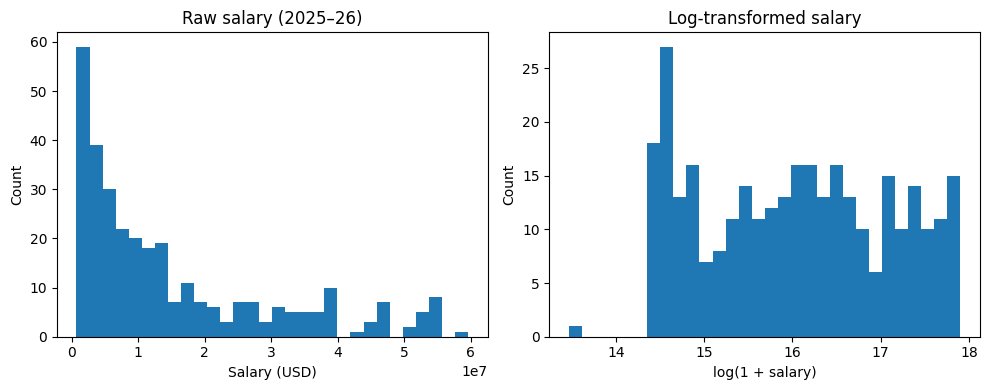

In [43]:
#statistical description of y
print("raw salary: \n", y_raw.describe())
print("log-transformed salary: \n", y.describe())
# histogram of salary
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

#raw salary
axes[0].hist(y_raw, bins=30)
axes[0].set_title("Raw salary (2025–26)")
axes[0].set_xlabel("Salary (USD)")
axes[0].set_ylabel("Count")

#log-transformed salary
axes[1].hist(y, bins=30)
axes[1].set_title("Log-transformed salary")
axes[1].set_xlabel("log(1 + salary)")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

In [34]:
# correlation matrix
corr_data = merged_clean.drop(['Rk', 'Player', 'Team', 'Pos', 'Awards', 'player_id', 'salary_2025_26'], axis=1)
corr_data.corr()

# EDA with candidate features
X.describe()

,G,MP,TS%,USG%,AST%,TRB%,STL%,BLK%,TOV%,BPM,WS,Age
count,316.000000,316.000000,316.000000,316.000000,316.000000,316.000000,316.000000,316.000000,316.000000,316.000000,316.000000,316.000000
mean,56.651899,1408.145570,0.571022,19.657595,15.172468,10.323734,1.669937,2.022468,12.253481,-0.378481,3.103165,25.348101
std,19.226941,737.807682,0.059608,5.844892,8.453009,4.405499,0.662186,1.683789,3.746341,3.097287,2.856892,4.114901
min,1.000000,5.000000,0.310000,6.000000,0.000000,3.400000,0.000000,0.000000,0.000000,-8.100000,-1.200000,19.000000
25%,46.000000,806.000000,0.540000,15.575000,8.600000,7.100000,1.200000,0.900000,9.600000,-2.500000,1.000000,22.000000
50%,61.500000,1426.000000,0.571000,18.750000,13.450000,9.200000,1.500000,1.500000,12.050000,-0.500000,2.500000,25.000000
75%,72.000000,1950.000000,0.605250,23.325000,19.625000,12.600000,2.000000,2.600000,14.500000,1.350000,4.600000,28.000000
max,82.000000,3036.000000,0.724000,42.200000,46.400000,23.400000,5.100000,10.400000,36.400000,13.300000,16.700000,40.000000


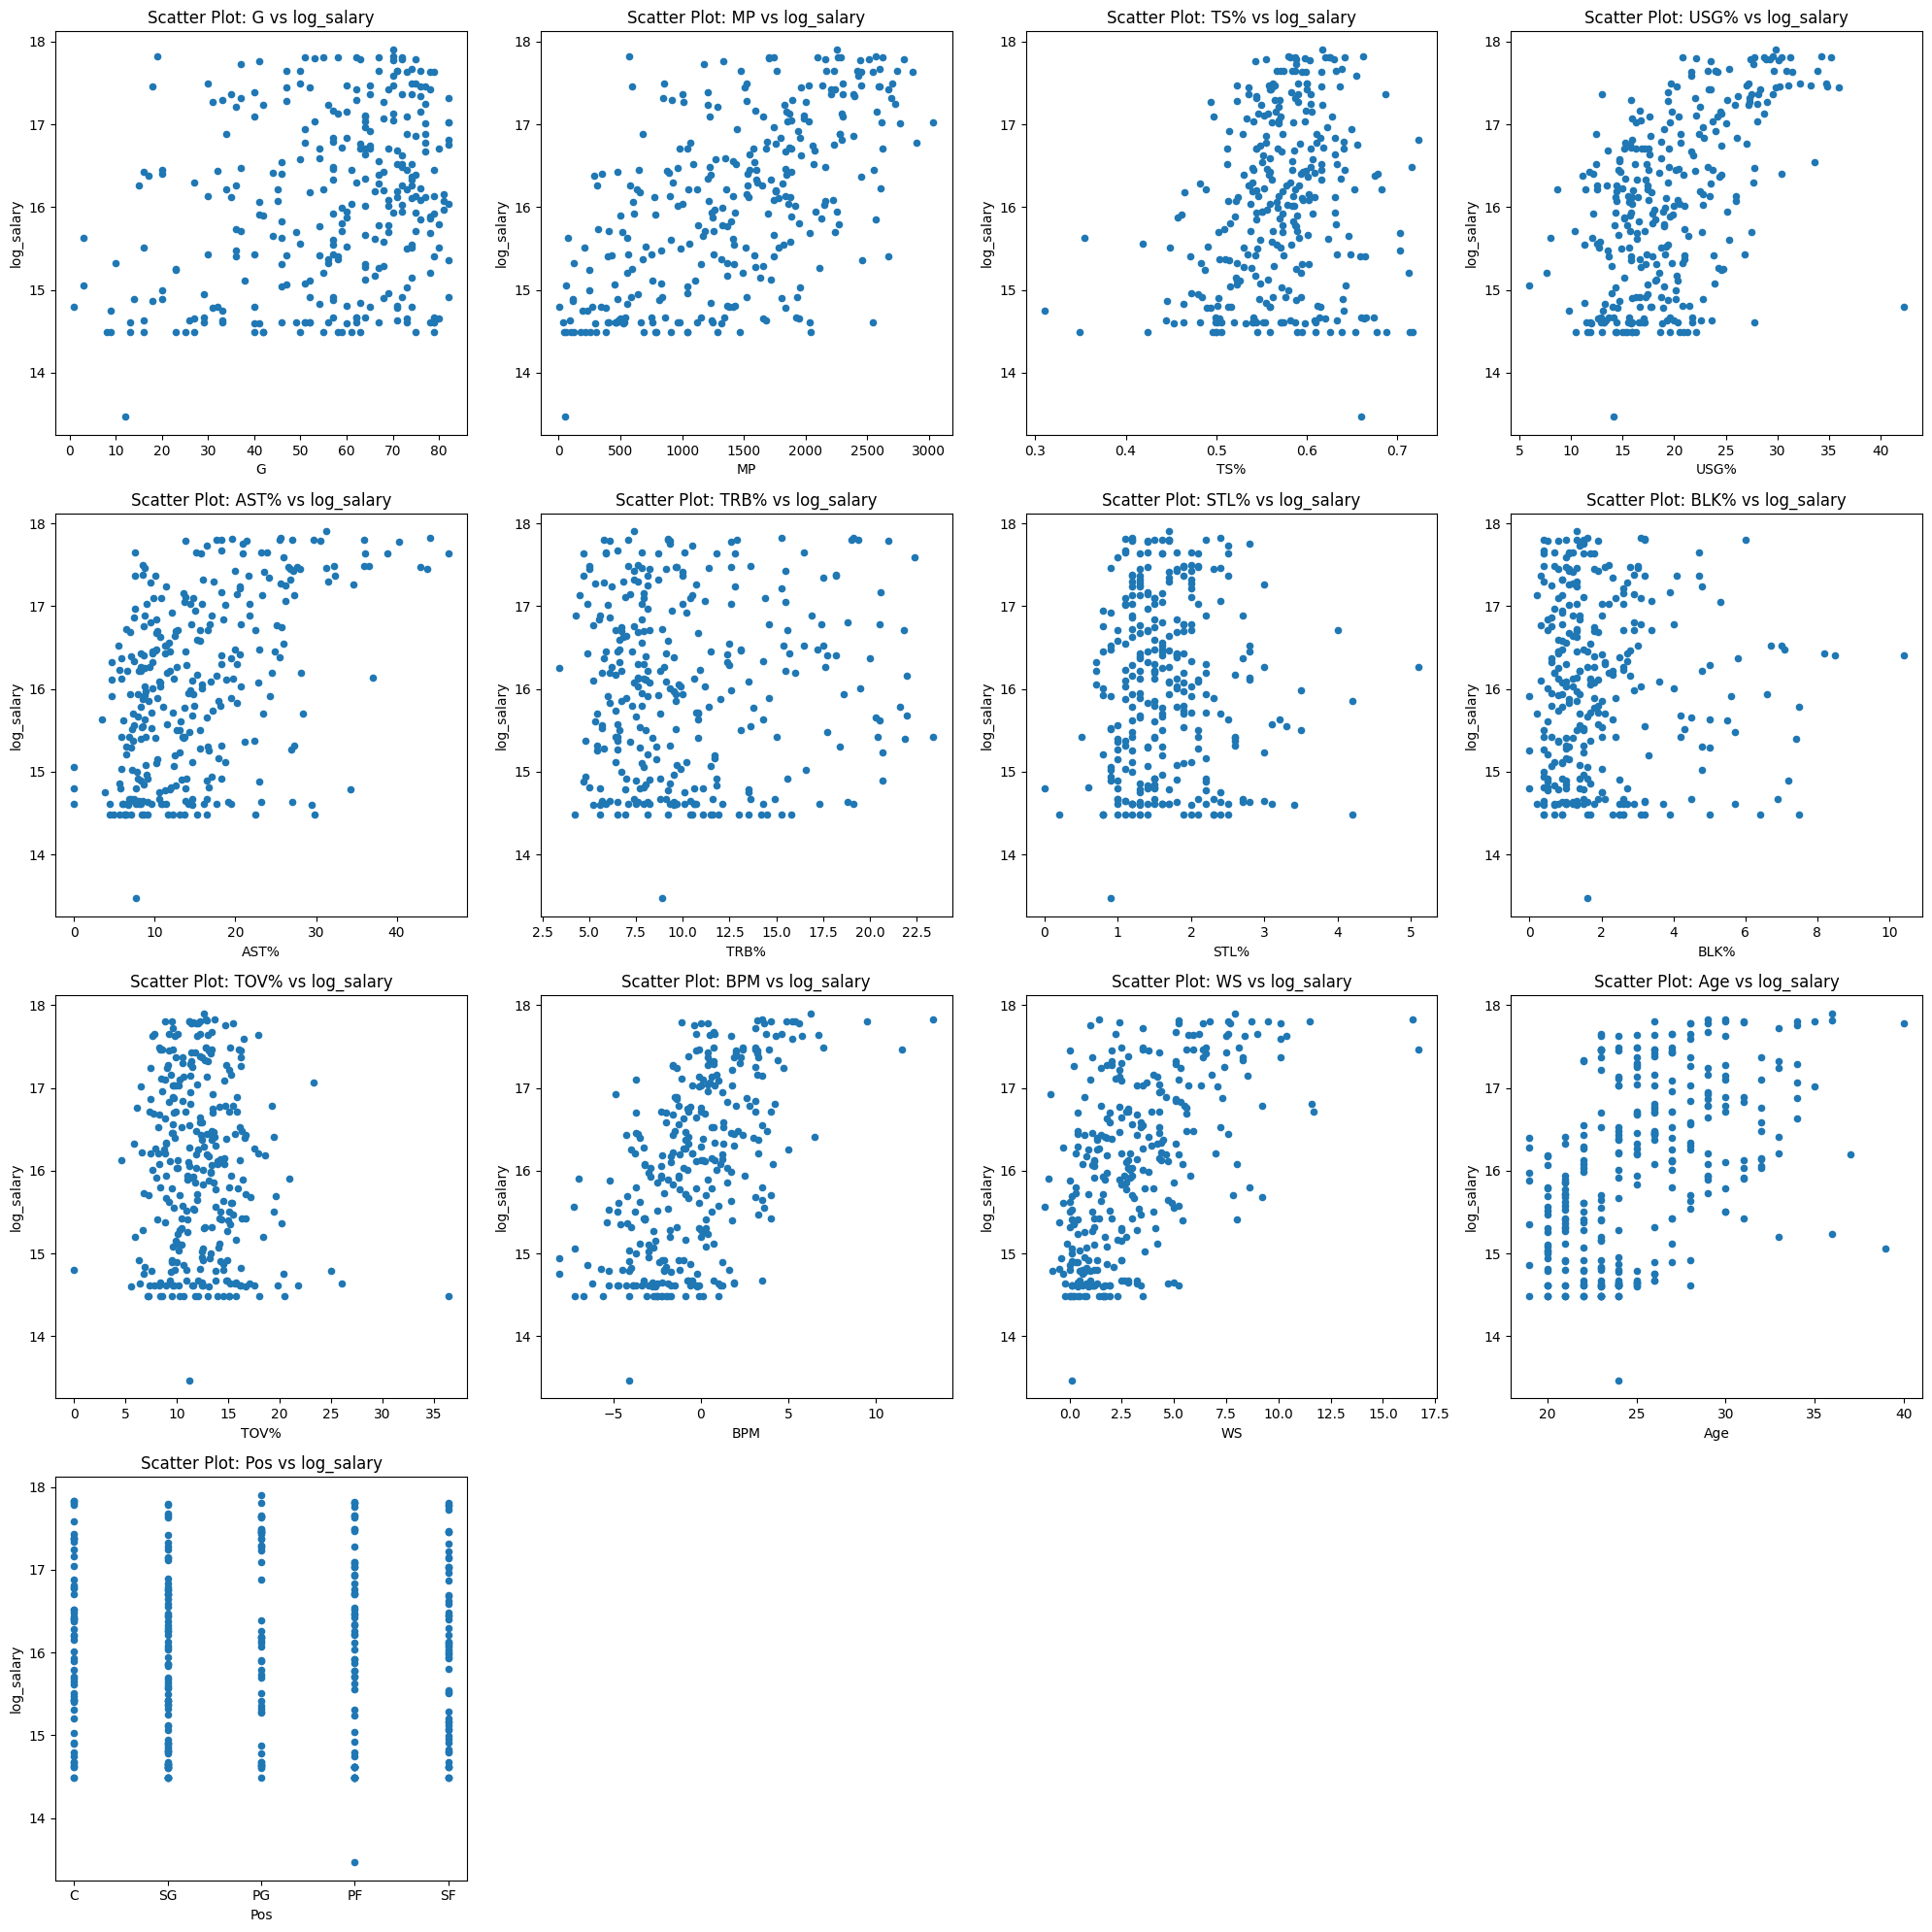

In [7]:
# scatterplots of y on X
fig, axes = plt.subplots(4, 4, figsize=(20, 20))
axes = axes.flatten()

for i, var_name in enumerate(X):
    merged_clean.plot.scatter(
        y='log_salary',
        x=var_name,
        ax=axes[i]
    )
    axes[i].set_title(f"Scatter Plot: {var_name} vs log_salary")

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

In [31]:
# correlation matrix
corr_data = merged_clean.drop(['Rk', 'Player', 'Team', 'Pos', 'Awards', 'player_id', 'salary_2025_26'], axis=1)
corr_data.corr()

,Age,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,...,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,log_salary
Age,1.000000,0.051051,0.208150,0.191287,0.248825,0.242076,0.001470,0.025729,-0.030926,0.060351,...,0.095730,0.316731,0.169412,0.290880,0.274704,0.323988,0.079245,0.309746,0.299001,0.484616
G,0.051051,1.000000,0.542481,0.811531,0.104757,0.181479,-0.041298,-0.019852,-0.087249,-0.095855,...,0.012295,0.445841,0.600515,0.543940,0.186838,0.211245,0.045099,0.197843,0.289655,0.269040
GS,0.208150,0.542481,1.000000,0.857942,0.432886,0.228332,-0.204241,0.189949,-0.070656,0.106948,...,0.379587,0.614015,0.667518,0.689703,0.307294,0.500066,0.047728,0.444653,0.560760,0.637254
MP,0.191287,0.811531,0.857942,1.000000,0.356093,0.246131,-0.091541,0.092249,-0.186458,-0.015755,...,0.320434,0.645767,0.717963,0.730897,0.278933,0.484494,0.006638,0.413101,0.539591,0.599452
PER,0.248825,0.104757,0.432886,0.356093,1.000000,0.607536,-0.530501,0.539082,0.302716,0.534753,...,0.612582,0.704704,0.501736,0.692519,0.805568,0.895452,0.277580,0.882154,0.776351,0.536205
TS%,0.242076,0.181479,0.228332,0.246131,0.607536,1.000000,-0.342434,0.325323,0.302406,0.264650,...,0.008080,0.568864,0.290456,0.516574,0.743682,0.583212,0.197996,0.582386,0.436749,0.204787
3PAr,0.001470,-0.041298,-0.204241,-0.091541,-0.530501,-0.342434,1.000000,-0.650959,-0.628007,-0.548569,...,-0.127979,-0.282802,-0.281116,-0.306611,-0.423144,-0.213847,-0.284781,-0.306080,-0.246197,-0.170063
FTr,0.025729,-0.019852,0.189949,0.092249,0.539082,0.325323,-0.650959,1.000000,0.355289,0.392514,...,0.309409,0.330803,0.169281,0.301493,0.397403,0.328157,0.145076,0.342350,0.302107,0.233646
ORB%,-0.030926,-0.087249,-0.070656,-0.186458,0.302716,0.302406,-0.628007,0.355289,1.000000,0.671042,...,-0.306300,0.143173,0.138770,0.153684,0.435331,0.020717,0.363199,0.175692,0.076709,-0.143058
DRB%,0.060351,-0.095855,0.106948,-0.015755,0.534753,0.264650,-0.548569,0.392514,0.671042,1.000000,...,0.132336,0.220800,0.336485,0.282181,0.439391,0.265915,0.366479,0.385633,0.322493,0.132639


In [6]:
#split the data into 2 sets with 20% testing and 80% training
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# preprocessor
X_train.shape, X_test.shape

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop="first", handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)


In [7]:
#Modeling 
results = []
fitted_models = {}

def evaluate_model(name, base_estimator, param_grid=None):
    pipe = Pipeline(steps=[
        ("prep", preprocessor),
        ("model", base_estimator)
    ])

    if param_grid:
        grid = GridSearchCV(
            pipe,
            param_grid={f"model__{k}": v for k, v in param_grid.items()},
            cv=5,
            scoring="neg_root_mean_squared_error",
            n_jobs=-1
        )
        grid.fit(X_train, y_train)
        best = grid.best_estimator_
        best_params = grid.best_params_
    else:
        best = pipe.fit(X_train, y_train)
        best_params = {}

    y_train_pred = best.predict(X_train)
    y_test_pred = best.predict(X_test)

    rmse_train = mean_squared_error(y_train, y_train_pred)**0.5
    rmse_test  = mean_squared_error(y_test, y_test_pred)**0.5

    mae_test = mean_absolute_error(y_test, y_test_pred)
    r2_test = r2_score(y_test, y_test_pred)

    results.append({
        "model": name,
        "rmse_train": rmse_train,
        "rmse_test": rmse_test,
        "mae_test": mae_test,
        "r2_test": r2_test,
        **{k.replace("model__", ""): v for k, v in best_params.items()}
    })

    fitted_models[name] = best
    print(f"{name}: RMSE_test={rmse_test:.3f}, MAE_test={mae_test:.3f}, R2_test={r2_test:.3f}")
    return best

# 1. Baseline OLS
ols = evaluate_model("OLS", LinearRegression())

# 2. Ridge Regression
ridge = evaluate_model(
    "Ridge",
    Ridge(),
    param_grid={"alpha": np.logspace(-3, 3, 7)}
)

# 3. Lasso Regression
lasso = evaluate_model(
    "Lasso",
    Lasso(max_iter=10000),
    param_grid={"alpha": np.logspace(-3, 1, 5)}
)

# 4. Random Forest
rf = evaluate_model(
    "RandomForest",
    RandomForestRegressor(random_state=42),
    param_grid={
        "n_estimators": [200, 400],
        "max_depth": [None, 5, 10],
        "min_samples_leaf": [1, 3]
    }
)

results_df = pd.DataFrame(results)
results_df.sort_values("rmse_test", inplace=True)
results_df.reset_index(drop=True, inplace=True)
results_df

OLS: RMSE_test=0.602, MAE_test=0.503, R2_test=0.591
Ridge: RMSE_test=0.600, MAE_test=0.506, R2_test=0.595
Lasso: RMSE_test=0.599, MAE_test=0.505, R2_test=0.596
RandomForest: RMSE_test=0.610, MAE_test=0.481, R2_test=0.581


,model,rmse_train,rmse_test,mae_test,r2_test,alpha,max_depth,min_samples_leaf,n_estimators
0,Lasso,0.582696,0.599055,0.504771,0.595897,0.01,NaN,NaN,NaN
1,Ridge,0.582474,0.599598,0.506127,0.595164,10.00,NaN,NaN,NaN
2,OLS,0.577708,0.602472,0.503120,0.591273,NaN,NaN,NaN,NaN
3,RandomForest,0.228453,0.609666,0.481421,0.581454,NaN,10.0,1.0,400.0


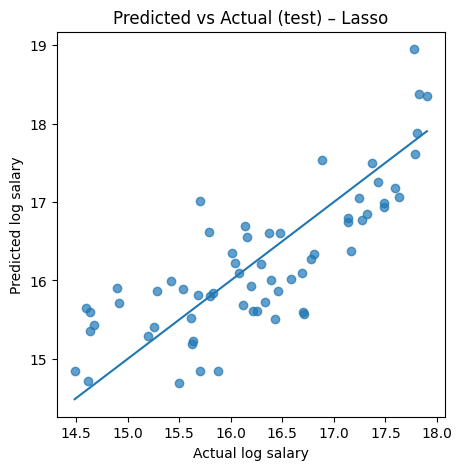

[Text(0.5, 1.0, 'Kernal Density Plot of Residuals'),
 Text(0.5, 0, 'Test Residual')]

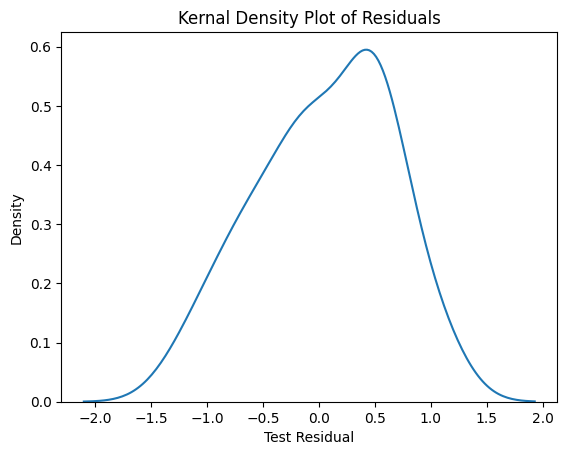

In [11]:
# Predicted vs. Actual y value of Lasso model (our best model)
best_name = results_df.iloc[0]["model"]
best_model = fitted_models[best_name]

y_test_pred = best_model.predict(X_test)

plt.figure(figsize=(5, 5))
plt.scatter(y_test, y_test_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()])
plt.xlabel("Actual log salary")
plt.ylabel("Predicted log salary")
plt.title(f"Predicted vs Actual (test) – {best_name}")
plt.show()

#residual plot of Lasso Model
sns.kdeplot(y_test - y_test_pred).set(title='Kernal Density Plot of Residuals', xlabel='Test Residual')

In [ ]:
#Look into Random Forest model -> check into predictor importance
rf_model = fitted_models["RandomForest"]
rf_est = rf_model.named_steps["model"]

# Get feature names after preprocessing
num_names = numeric_features
if categorical_features:
    ohe = rf_model.named_steps["prep"].named_transformers_["cat"]
    cat_names = ohe.get_feature_names_out(categorical_features).tolist()
else:
    cat_names = []

feature_names = num_names + cat_names
importances = rf_est.feature_importances_

fi = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

fi.head(15)

,feature,importance
3,USG%,0.249946
11,Age,0.234656
1,MP,0.172309
9,BPM,0.100810
10,WS,0.083616
4,AST%,0.025299
0,G,0.024836
5,TRB%,0.022618
2,TS%,0.021705
7,BLK%,0.021237


In [ ]:
#comparing predictors of Ridge and Lasso models
ridge_model = fitted_models["Ridge"]
lasso_model = fitted_models["Lasso"]

ridge_coef = ridge_model.named_steps["model"].coef_
lasso_coef = lasso_model.named_steps["model"].coef_

coef_df = pd.DataFrame({
    "feature": feature_names,
    "ridge_coef": ridge_coef,
    "lasso_coef": lasso_coef
}).sort_values("ridge_coef", key=lambda x: x.abs(), ascending=False)

coef_df.head(15)

,feature,ridge_coef,lasso_coef
1,MP,0.556392,0.630459
11,Age,0.369225,0.372011
3,USG%,0.265503,0.261971
0,G,-0.219107,-0.256518
9,BPM,0.196560,0.198051
7,BLK%,0.135244,0.115433
2,TS%,-0.117792,-0.106730
13,Pos_PG,-0.110467,-0.000000
14,Pos_SF,0.077139,0.047247
4,AST%,0.064196,0.033616
